# Predictive Maintenance using Machine Learning on Sagemaker
*Part 2 - Exploratory data analysis*

## Initialization
---
Directory structure to run this notebook:
```
sagemaker-predictive-maintenance
|
+--- data
|   |
|   +--- interim: intermediate data we can manipulate and process
|   |
|   \--- raw: *immutable* data downloaded from the source website
|
+--- notebooks: all the notebooks are positionned here
```

### Loading data from the previous notebook

In [1]:
%store -r

### Notebook instance update

Updating `seaborn` and `pandas` to last version:

In [2]:
import seaborn as sns
sns_version = sns.__version__
if (sns_version != '0.10.0'):
    !pip install seaborn==0.10.0
    print('*** New version of seaborn installed, kernel restart might be needed. ***')
else:
    print('Latest version for seaborn found, no upgrade needed.')

import pandas as pd
pd_version = pd.__version__
if (pd_version != '1.0.3'):
    !pip install pandas==1.0.3
    print('*** New version of pandas installed, kernel restart might be needed. ***')
else:
    print('Latest version for pandas found, no upgrade needed.')

Latest version for seaborn found, no upgrade needed.
Latest version for pandas found, no upgrade needed.


In [3]:
import matplotlib.pyplot as plt
import sagemaker
import boto3

sns.set_style('darkgrid')

## Exploratory data analysis
---
### Timeseries overview
Ploting data for a given engine (unit) to get a feeling about what is happening with these data:

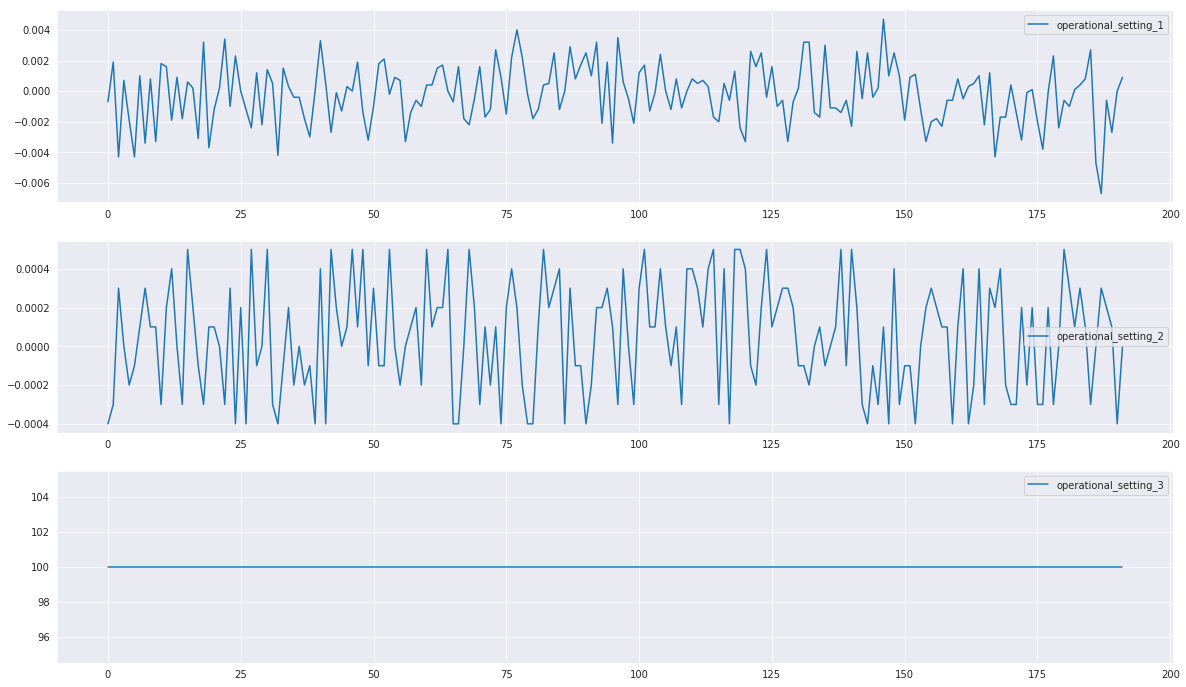

In [4]:
unit = 1 # Engine number to analyze
unit_data = data[data['unit_number'] == unit]

fig = plt.figure(figsize=(20,12))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    sns.lineplot(data=unit_data[['operational_setting_{}'.format(i+1)]])

**Comments:** it looks like `operation setting 3` is not changing over time. If this is true for all units, this is an easy feature to remove from the modeling phase.

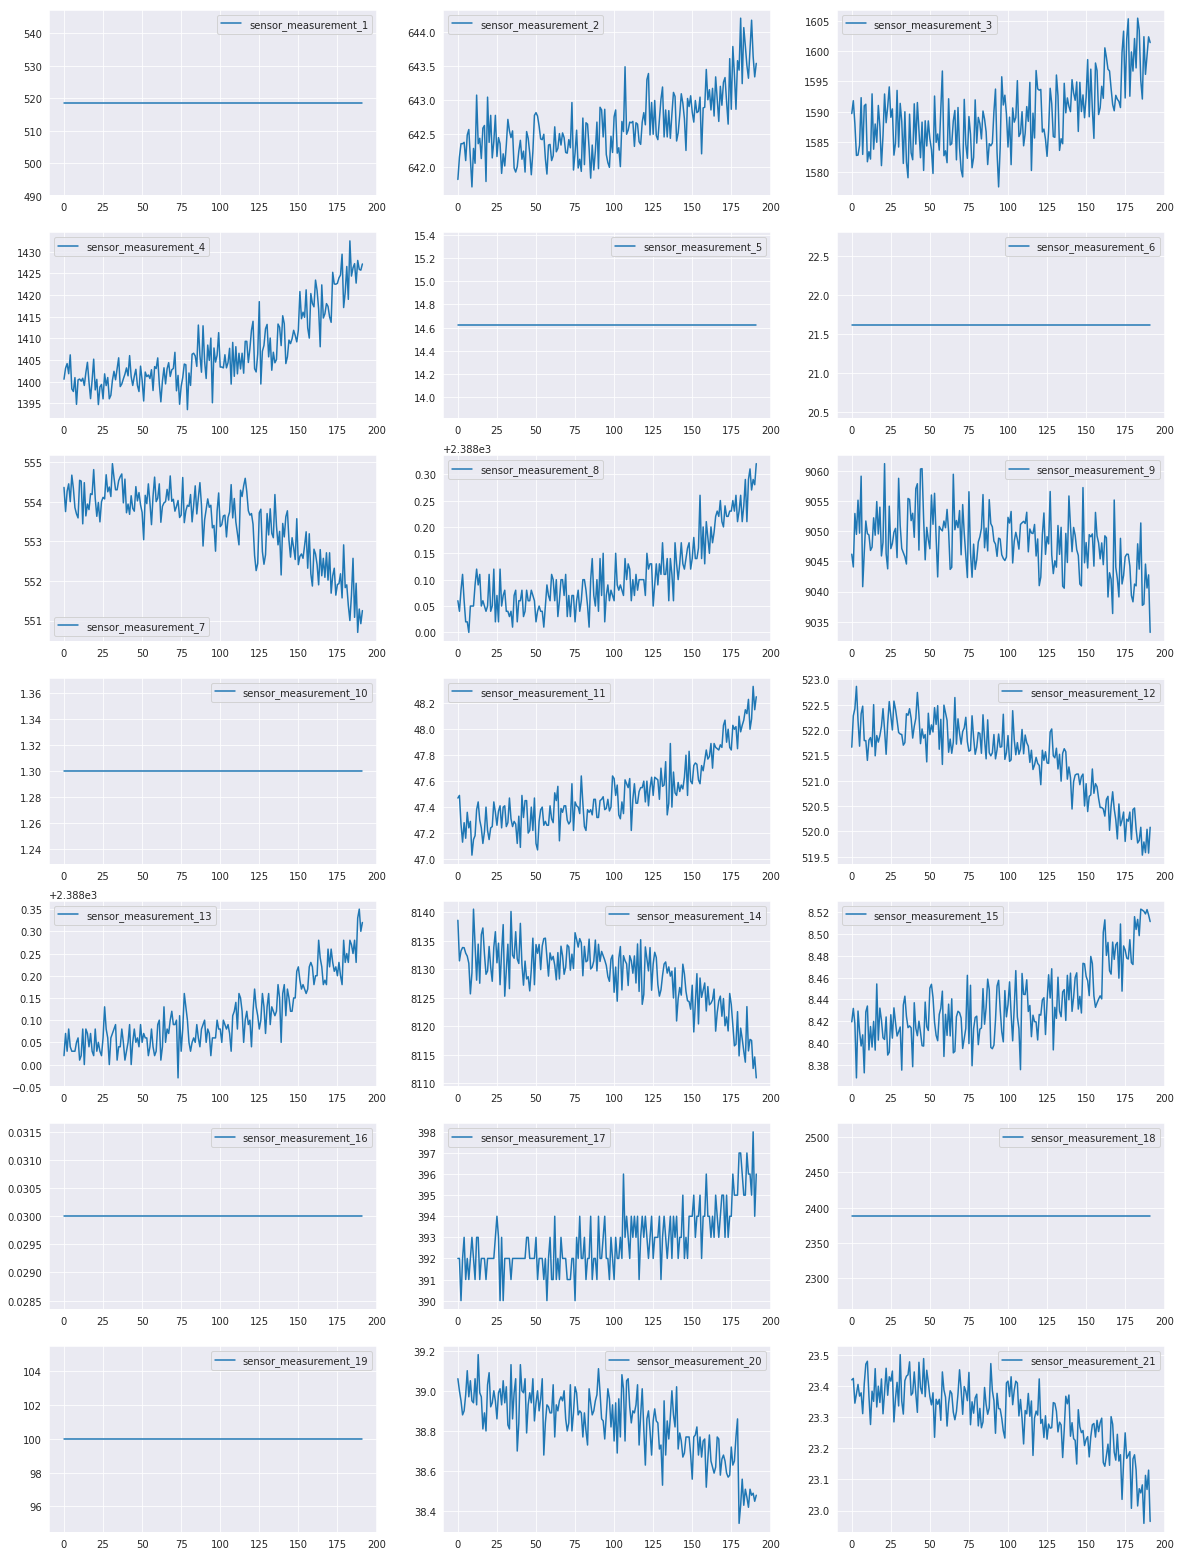

In [5]:
fig = plt.figure(figsize=(20,28))
for i in range(21):
    plt.subplot(7, 3, i + 1)
    sns.lineplot(data=unit_data[['sensor_measurement_{}'.format(i+1)]])

**Comments:**
* Checking the sensor measurements, it's pretty obvious when things are starting to go awry. Surprisingly, suspicious behaviour starts very early but that may be because the dataset is pretty limited.
* We can also note many signals have a low variance over time (it looks like they are even constant): checking over the whole dataset will help further simplifying it.

### Data profiling
Let's profile the dataframe to identify features to eliminate.

In [6]:
# Low variance columns (standard deviation lower than 1e-10) are removed from the dataset:
std = data.loc[:, 'operational_setting_1':].std()
features_to_remove = std[std <= 1e-10].index.tolist()
data = data.drop(columns=features_to_remove)
data.head()

,unit_number,time,operational_setting_1,operational_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21,rul
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [7]:
data.describe()

,unit_number,time,operational_setting_1,operational_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21,rul
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,642.680934,1590.523119,1408.933782,21.609803,553.367711,2388.096652,9065.242941,47.541168,521.413470,2388.096152,8143.752722,8.442146,393.210654,38.816271,23.289705,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.500053,6.131150,9.000605,0.001389,0.885092,0.070985,22.082880,0.267087,0.737553,0.071919,19.076176,0.037505,1.548763,0.180746,0.108251,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,641.210000,1571.040000,1382.250000,21.600000,549.850000,2387.900000,9021.730000,46.850000,518.690000,2387.880000,8099.940000,8.324900,388.000000,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,642.325000,1586.260000,1402.360000,21.610000,552.810000,2388.050000,9053.100000,47.350000,520.960000,2388.040000,8133.245000,8.414900,392.000000,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,642.640000,1590.100000,1408.040000,21.610000,553.440000,2388.090000,9060.660000,47.510000,521.480000,2388.090000,8140.540000,8.438900,393.000000,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,643.000000,1594.380000,1414.555000,21.610000,554.010000,2388.140000,9069.420000,47.700000,521.950000,2388.140000,8148.310000,8.465600,394.000000,38.950000,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,644.530000,1616.910000,1441.490000,21.610000,556.060000,2388.560000,9244.590000,48.530000,523.380000,2388.560000,8293.720000,8.584800,400.000000,39.430000,23.618400,361.000000


From the previous describe command, we can note that the different features have very different ranges. Normalization will be necessary if we want to get some results from our model.

### Storing data for the next notebook

In [8]:
%store data

Stored 'data' (DataFrame)
